In [52]:
import pandas as pd
import glob
import os
import shutil
import re

from plotnine import *
from datetime import datetime

from scipy.spatial import distance
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [78]:
entry_directory = "Raw"
prepared_directory = "Prepared"
organised_directory = "Organised"

In [ ]:
def calculate_sums(file_path):

    node_data_df = pd.read_csv(file_path, dtype = {'timestamp' : 'string', 'PID' : 'int', 'CPU': 'float64', 'RAM': 'float64'})
    node_data_df['timestamp'] = node_data_df['timestamp'].apply(lambda x: x if len(x.split(".")) > 1 else x + ".000000" )
    node_data_df['epoch'] = node_data_df['timestamp'].apply(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") - datetime(1970, 1, 1)).total_seconds())
    min_timestamp = node_data_df['epoch'].min()
    node_data_df['epoch'] = node_data_df['epoch'].apply(lambda x: x - min_timestamp)
    node_data_df.drop('PID', axis='columns', inplace=True)
    node_data_df.drop('timestamp', axis='columns', inplace=True)
    node_data_df = node_data_df.groupby("epoch").sum()

    return node_data_df


for root, _, files in os.walk(f".\{entry_directory}"):
        for file in files:
            full_path = os.path.join(root, file)
            if re.search("\d\d_\d\d_\d\d\d\d_\d\d_\d\d_\d\d.csv$", full_path):
                if os.path.exists(full_path.replace(entry_directory, prepared_directory)):
                    continue
                calculated_dataframe_to_save = calculate_sums(full_path)
                if not os.path.exists(root.replace(entry_directory, prepared_directory)):
                    os.makedirs(root.replace(entry_directory, prepared_directory))
                calculated_dataframe_to_save.to_csv(full_path.replace(entry_directory, prepared_directory))

In [ ]:
root = ".\Prepared"
for functionTypeDirectory in os.listdir(root):
    if os.path.isdir(os.path.join(root, functionTypeDirectory)):
        for functionDirectory in os.listdir(os.path.join(root, functionTypeDirectory)):
            for numberOfNodesDirectory in os.listdir(os.path.join(root, functionTypeDirectory, functionDirectory)):
                destinationPath =  os.path.join(root, functionTypeDirectory, functionDirectory, numberOfNodesDirectory, 'source-data')
                for nodeDirectory in os.listdir(destinationPath):
                    path =  os.path.join(destinationPath, nodeDirectory)
                    all_files = glob.glob(path + "/*.csv")
                    dfs = []
                    i = 1
                    for filename in all_files:
                        df = pd.read_csv(filename)
                        dfs.append(df)
                        if df['RAM'].mean() >= 2 and df['CPU'].head(15).mean() > 3:
                            if not os.path.exists(os.path.join(destinationPath.replace("Prepared", "Organised"), str(i))):
                                os.makedirs(os.path.join(destinationPath.replace("Prepared", "Organised"), str(i)))
                            shutil.copyfile(filename, os.path.join(destinationPath.replace("Prepared", "Organised"), str(i), os.path.basename(filename)))
                        i += 1


In [79]:
def join_files(entry_dir, category):
    directory = f"./{entry_dir}/{category}"
    udf_dirs = os.listdir(directory)
    label = category
    result_df = pd.DataFrame()
    snapshot = 0
    for udf in udf_dirs:
        for root, _, files in os.walk(f"./{directory}/{udf}"):
            for file in files:
                full_path = os.path.join(root, file)
                node_data_df = pd.read_csv(full_path)
                node_data_df['snapshot'] = snapshot
                snapshot += 1
                node_data_df["label"] = label
                node_data_df["udf"] = udf
                result_df = pd.concat([result_df,node_data_df])
    result_df[["snapshot", "label", "udf", "epoch", "CPU", "RAM"]].to_csv(f"{directory}/joined_{category}.csv", index = False)

labels = ['aggregation', 'filtration', 'filtration-aggregation', 'filtration-aggregation-join', 'filtration-join']

for label in labels:
    join_files(organised_directory, label)

In [80]:
def smooth_values(entry_dir, category, window_value,):
    # reading file
    path_to_df = f"./{entry_dir}/{category}/joined_{category}.csv"
    df = pd.read_csv(path_to_df)
    cpu_df = df.groupby('snapshot')['CPU'].rolling(window=window_value, min_periods = 1).mean().to_frame()
    ram_df = df.groupby('snapshot')['RAM'].rolling(window=window_value, min_periods = 1).mean().to_frame()
    df['CPU'] = cpu_df.reset_index()['CPU'] 
    df['CPU'] = df['CPU'].round(2)
    df['RAM'] = ram_df.reset_index()['RAM']
    df['RAM'] = df['RAM'].round(2)
    df['epoch'] = df['epoch'].round(3)
    df.fillna(0).to_csv(f"./{entry_dir}/{category}/{window_value}_smooth_{category}.csv", index = False)

for label in labels:
    smooth_values(organised_directory, label, 6)

In [30]:
%matplotlib inline
joined_aggregation_all = pd.read_csv("Organised/aggregation/joined_aggregation.csv")
joined_aggregation = joined_aggregation_all[joined_aggregation_all["snapshot"] == 1]

#(ggplot(joined_aggregation)         # defining what data to use
#  + aes(x='epoch', y = "CPU")    # defining what variable to use
#  + geom_line(size=0.5, color = "red") # defining the type of plot to use
# )

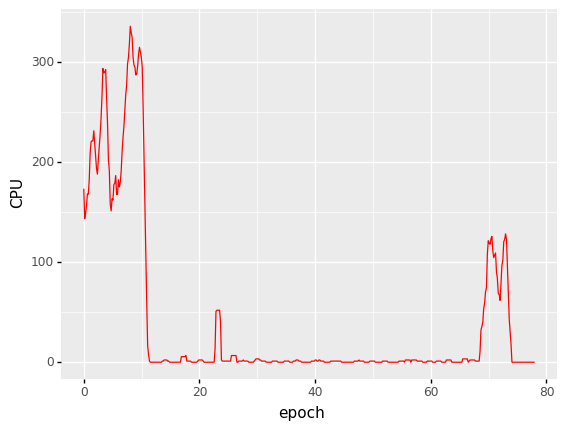

<ggplot: (126105603094)>

In [35]:
joined_aggregation_smooth_all = pd.read_csv("Organised/aggregation/6_smooth_aggregation.csv")
joined_aggregation_smooth = joined_aggregation_smooth_all[joined_aggregation_smooth_all["snapshot"] == 1]

(ggplot(joined_aggregation_smooth)         # defining what data to use
 + aes(x='epoch', y = "CPU")    # defining what variable to use
 + geom_line(size=0.5, color = "red") # defining the type of plot to use
)

In [89]:
def calculate_euclidean_distance(data, snapshot1, snapshot2):
    a = data[data["snapshot"] == snapshot1].head(496)
    b = data[data["snapshot"] == snapshot2].head(496)
    cpu_dst = distance.euclidean(a['CPU'], b['CPU'])
    ram_dst = distance.euclidean(a['RAM'], b['RAM'])
    print("snapshot:"+str(snapshot1)+" and "+"snapshot:"+str(snapshot2))
    print("CPU distance:"+str(cpu_dst))
    print("RAM distance:"+str(ram_dst))
    print("\n")

def calculate_dtw(data, snapshot1, snapshot2, data2=pd.DataFrame()):
    if data2.empty:
        data2 = data
    a = data[data["snapshot"] == snapshot1].head(496)
    b = data2[data2["snapshot"] == snapshot2].head(496)
    alignment_cpu = dtw(a['CPU'], b['CPU'], keep_internals=True)
    alignment_ram = dtw(a['RAM'], b['RAM'], keep_internals=True)
    print("snapshot:"+str(snapshot1)+" and "+"snapshot:"+str(snapshot2))
    print("CPU distance:"+str(alignment_cpu.distance))
    print("CPU normalized distance:"+str(alignment_cpu.normalizedDistance))
    print("RAM distance:"+str(alignment_ram.distance))
    print("RAM normalized distance:"+str(alignment_ram.normalizedDistance))
    print("\n")
    #alignment.plot(type="threeway")
    #dtw(a['CPU'], b['CPU'], keep_internals=True,
    #step_pattern=rabinerJuangStepPattern(6, "c"))\
    #.plot(type="twoway",offset=-2)

In [78]:
calculate_euclidean_distance(joined_aggregation_all, 0, 1)
calculate_euclidean_distance(joined_aggregation_all, 0, 2)
calculate_euclidean_distance(joined_aggregation_all, 1, 2)

snapshot:0 and snapshot:1
CPU distance:982.2344526639248
RAM distance:34.884523789210604


snapshot:0 and snapshot:2
CPU distance:466.87459772405697
RAM distance:4.543126676640235


snapshot:1 and snapshot:2
CPU distance:984.4933265390883
RAM distance:33.514922049737784




In [90]:
calculate_dtw(joined_aggregation_all, 0, 1)
calculate_dtw(joined_aggregation_all, 0, 2)
calculate_dtw(joined_aggregation_all, 1, 2)

snapshot:0 and snapshot:1
CPU distance:5160.199999999988
CPU normalized distance:5.20181451612902
RAM distance:228.10000000000008
RAM normalized distance:0.22993951612903235


snapshot:0 and snapshot:2
CPU distance:2352.5999999999976
CPU normalized distance:2.371572580645159
RAM distance:126.20000000000132
RAM normalized distance:0.1272177419354852


snapshot:1 and snapshot:2
CPU distance:4878.3999999999905
CPU normalized distance:4.917741935483861
RAM distance:194.2
RAM normalized distance:0.19576612903225804




In [91]:
calculate_euclidean_distance(joined_aggregation_smooth_all, 0, 1)
calculate_euclidean_distance(joined_aggregation_smooth_all, 0, 2)
calculate_euclidean_distance(joined_aggregation_smooth_all, 1, 2)

snapshot:0 and snapshot:1
CPU distance:693.6797718688357
RAM distance:32.895730726037996


snapshot:0 and snapshot:2
CPU distance:247.45143786205813
RAM distance:4.475075418358908


snapshot:1 and snapshot:2
CPU distance:672.6505059836051
RAM distance:31.539682940701862




In [92]:
calculate_dtw(joined_aggregation_smooth_all, 0, 1)
calculate_dtw(joined_aggregation_smooth_all, 0, 2)
calculate_dtw(joined_aggregation_smooth_all, 1, 2)

snapshot:0 and snapshot:1
CPU distance:2954.6799999999675
CPU normalized distance:2.978508064516096
RAM distance:192.11000000000018
RAM normalized distance:0.1936592741935486


snapshot:0 and snapshot:2
CPU distance:1037.34
CPU normalized distance:1.0457056451612903
RAM distance:97.67000000000156
RAM normalized distance:0.09845766129032416


snapshot:1 and snapshot:2
CPU distance:2961.989999999971
CPU normalized distance:2.9858770161290034
RAM distance:180.57
RAM normalized distance:0.18202620967741934




In [94]:
# Compare two different functions
joined_filtration_all = pd.read_csv("Organised/filtration/joined_filtration.csv")
calculate_dtw(joined_aggregation_all, 0, 1, joined_filtration_all)
calculate_dtw(joined_aggregation_all, 0, 2, joined_filtration_all)
calculate_dtw(joined_aggregation_all, 1, 2, joined_filtration_all)


snapshot:0 and snapshot:1
CPU distance:3491.199999999994
CPU normalized distance:5.395981452859341
RAM distance:190.3999999999998
RAM normalized distance:0.2942812982998451


snapshot:0 and snapshot:2
CPU distance:3374.599999999993
CPU normalized distance:5.314330708661406
RAM distance:201.0
RAM normalized distance:0.3165354330708661


snapshot:1 and snapshot:2
CPU distance:4265.199999999994
CPU normalized distance:6.716850393700779
RAM distance:144.99999999999997
RAM normalized distance:0.22834645669291334


